In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Understanding the Business Problem
Uber Inc in the US wants to know:

- the major complaints premium users have about their cab services,
- how these impact service ratings.

We as (technical) consultants to Uber. have to:  
- [a] analyze text reviews of Uber cabs’ US services,  
- [b] relate whether and which different features of these reviews impact overall ratings  
- [c] pinpoint possible areas of improvement.

### 1. Pre-processing: 
- Examine the dataset. 
- ID the columns of interest. 
- Drop special characters, html junk etc. 
- Perform any other preprocessing and text-cleaning activity you think fits this context.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/uber_reviews_itune.csv",
                 encoding='cp1252')
df.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


Columns of interest:  
1. Title - Brief summary about the review
2. Rating - Label for supervised learning
3. Review - To extract the sentiment of the complaint
4. Date - Extracting weekday or weekend may give better insight on nature of review

### Data Cleaning

In [3]:
df1 = df.drop(['Author_Name','Author_URL','App_Version'],axis=1)
df1.head()

,Title,Rating,Review,Date
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,Free offer,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,bad,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


In [4]:
# Replacing emoticon with its respective meaning
df_emojis = pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/emoji_description.csv")
df_emojis['Code'] = df_emojis['Code'].str.replace('+','+000')
df_emojis.head()

,Code,CLDR Short Name
0,<U+0001F600>,grinning face
1,<U+0001F603>,grinning face with big eyes
2,<U+0001F604>,grinning face with smiling eyes
3,<U+0001F601>,beaming face with smiling eyes
4,<U+0001F606>,grinning squinting face


In [5]:
# Replacing emoticon with its respective meaning
to_replace = df_emojis.Code.tolist()
replace_with = df_emojis['CLDR Short Name'].tolist()

# using zip() to convert lists to dictionary
res = dict(zip(to_replace, replace_with))

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j + ". ")
    return text

In [6]:
df1.Review = df1.Review.apply(lambda text: replace_all(text, res))
df1.Review[1]

'If I’m not eligible for the offer Stop flooding my email with this false information pouting face. pouting face. pouting face. '

In [7]:
df1.Review = df1.Review.str.split('<').str[0]
df1.shape

(490, 4)

In [8]:
df1.Review[1]

'If I’m not eligible for the offer Stop flooding my email with this false information pouting face. pouting face. pouting face. '

In [9]:
df1['Review'].replace('', np.nan, inplace=True)
df1.dropna(subset=['Review'], inplace=True)
df1.shape

(489, 4)

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# define unit func to process one doc
from nltk import sent_tokenize, word_tokenize
def vader_unit_func(doc0,column_name):
    sents_list0 = sent_tokenize(doc0)
    vs_doc0 = []
    sent_ind = []
    for i in range(len(sents_list0)):
        vs_sent0 = analyzer.polarity_scores(sents_list0[i])
        vs_doc0.append(vs_sent0)
        sent_ind.append(i)
        
    # obtain output as DF    
    doc0_df = pd.DataFrame(vs_doc0)
    doc0_df.columns = [x+column_name for x in doc0_df.columns]
    doc0_df.insert(0, 'sent_index', sent_ind)  # insert sent index
    doc0_df.insert(doc0_df.shape[1], 'sentence', sents_list0)
    return(doc0_df)

# define wrapper func
def vader_wrap_func(corpus0,column_name):
    
    # use ifinstance() to check & convert input to DF
    if isinstance(corpus0, list):
        corpus0 = pd.DataFrame({'text':corpus0})
    
    # define empty DF to concat unit func output to
    vs_df = pd.DataFrame()    
    
    # apply unit-func to each doc & loop over all docs
    for i1 in range(len(corpus0)):
        doc0 = str(corpus0.iloc[i1])
        vs_doc_df = vader_unit_func(doc0,column_name)  # applying unit-func
        vs_doc_df.insert(0, 'doc_index', i1)  # inserting doc index
        vs_df = pd.concat([vs_df, vs_doc_df], axis=0)
        
    return(vs_df)

In [11]:
# test-drive wrapper func
review_sentiment = vader_wrap_func(df1.Review,'_review').groupby('doc_index').sum()
title_sentiment = vader_wrap_func(df1.Title,'_title').groupby('doc_index').sum()
df1 = pd.concat([df1,review_sentiment,title_sentiment],axis=1)
print(df1.shape)
df1.head()

(490, 14)


,Title,Rating,Review,Date,sent_index,neg_review,neu_review,pos_review,compound_review,sent_index,neg_title,neu_title,pos_title,compound_title
0,Dishonest and Disgusting,1.0,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14,3.0,0.000,2.876,0.124,0.1406,0.0,0.877,0.123,0.000,-0.7964
1,Free offer,2.0,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17,3.0,0.121,2.879,0.000,-0.2960,0.0,0.000,0.233,0.767,0.5106
2,Inaccurate,2.0,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38,0.0,0.179,0.821,0.000,-0.3400,0.0,0.000,1.000,0.000,0.0000
3,bad,1.0,i had my rides canceled back to back. they the...,08-12-2020 01:01,10.0,1.167,3.592,0.241,-0.1617,0.0,1.000,0.000,0.000,-0.5423
4,Double charged me for an order,1.0,Two of the same orders was added by accident. ...,15-12-2020 04:02,21.0,0.908,5.614,0.478,-0.4906,0.0,0.265,0.735,0.000,-0.2023


In [12]:
# Converting Date into datetime format
df1['Date'] =  pd.to_datetime(df1['Date'], format='%d-%m-%Y %H:%M')
df1.Date.head()

0   2020-12-29 01:14:00
1   2021-01-01 23:17:00
2   2021-01-15 23:38:00
3   2020-12-08 01:01:00
4   2020-12-15 04:02:00
Name: Date, dtype: datetime64[ns]

In [13]:
df1['Isweekend'] = np.where(df1.Date.dt.dayofweek>4,1,0)
df1['Late_night'] = np.where(df1.Date.dt.hour<4,1,0)
df1['Early_mrng'] = np.where(df1.Date.dt.hour.between(4,8),1,0)
df1['Morning'] = np.where(df1.Date.dt.hour.between(8,12),1,0)
df1['Noon'] = np.where(df1.Date.dt.hour.between(12,16),1,0)
df1['Eve'] = np.where(df1.Date.dt.hour.between(16,20),1,0)
df1['Night'] = np.where(df1.Date.dt.hour>20,1,0)
df1.head()

,Title,Rating,Review,Date,sent_index,neg_review,neu_review,pos_review,compound_review,sent_index,...,neu_title,pos_title,compound_title,Isweekend,Late_night,Early_mrng,Morning,Noon,Eve,Night
0,Dishonest and Disgusting,1.0,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,3.0,0.000,2.876,0.124,0.1406,0.0,...,0.123,0.000,-0.7964,0,1,0,0,0,0,0
1,Free offer,2.0,If I’m not eligible for the offer Stop floodin...,2021-01-01 23:17:00,3.0,0.121,2.879,0.000,-0.2960,0.0,...,0.233,0.767,0.5106,0,0,0,0,0,0,1
2,Inaccurate,2.0,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,0.0,0.179,0.821,0.000,-0.3400,0.0,...,1.000,0.000,0.0000,0,0,0,0,0,0,1
3,bad,1.0,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,10.0,1.167,3.592,0.241,-0.1617,0.0,...,0.000,0.000,-0.5423,0,1,0,0,0,0,0
4,Double charged me for an order,1.0,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,21.0,0.908,5.614,0.478,-0.4906,0.0,...,0.735,0.000,-0.2023,0,0,1,0,0,0,0


In [14]:
df1=df1.drop(['sent_index','Title','Review','Date'],axis=1)
df1.head()

,Rating,neg_review,neu_review,pos_review,compound_review,neg_title,neu_title,pos_title,compound_title,Isweekend,Late_night,Early_mrng,Morning,Noon,Eve,Night
0,1.0,0.000,2.876,0.124,0.1406,0.877,0.123,0.000,-0.7964,0,1,0,0,0,0,0
1,2.0,0.121,2.879,0.000,-0.2960,0.000,0.233,0.767,0.5106,0,0,0,0,0,0,1
2,2.0,0.179,0.821,0.000,-0.3400,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,1
3,1.0,1.167,3.592,0.241,-0.1617,1.000,0.000,0.000,-0.5423,0,1,0,0,0,0,0
4,1.0,0.908,5.614,0.478,-0.4906,0.265,0.735,0.000,-0.2023,0,0,1,0,0,0,0


In [15]:
# Removing null values
df1.dropna(inplace=True)

### Preliminary Regression Model


In [16]:
y = df1.Rating
X = df1.drop('Rating', axis=1)
y.shape, X.shape

((488,), (488, 15))

In [25]:
# Standardizing continuous variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
X_sc.head()

,neg_review,neu_review,pos_review,compound_review,neg_title,neu_title,pos_title,compound_title,Isweekend,Late_night,Early_mrng,Morning,Noon,Eve,Night
0,-0.875619,-0.091833,-0.403406,0.357181,1.956432,-1.534357,-0.399319,-2.086153,-0.650185,2.074692,-0.412630,-0.385013,-0.478768,-0.627922,-0.485225
1,-0.605197,-0.090805,-0.716363,-0.171364,-0.754779,-1.249317,3.445899,1.963698,-0.650185,-0.481999,-0.412630,-0.385013,-0.478768,-0.627922,2.060901
2,-0.475573,-0.795972,-0.716363,-0.224630,-0.754779,0.738188,-0.399319,0.381560,-0.650185,-0.481999,-0.412630,-0.385013,-0.478768,-0.627922,2.060901
3,1.732497,0.153502,-0.108117,-0.008782,2.336682,-1.853083,-0.399319,-1.298803,-0.650185,2.074692,-0.412630,-0.385013,-0.478768,-0.627922,-0.485225
4,1.153661,0.846334,0.490034,-0.406946,0.064458,0.051502,-0.399319,-0.245284,-0.650185,-0.481999,2.423477,-0.385013,-0.478768,-0.627922,-0.485225


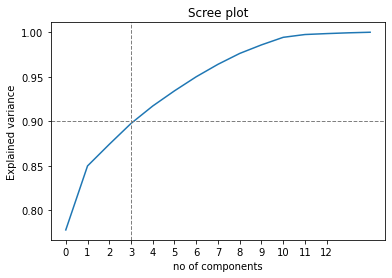

In [29]:
# Applying PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA().fit(X)

# Plot the scree plot to see how many components explain how much variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("no of components")
plt.ylabel("Explained variance")
plt.title("Scree plot")
plt.xticks(np.arange(0,13,1))
plt.axhline(y=0.9, c='grey', lw=1, linestyle='dashed')
plt.axvline(x=3, c='grey', lw=1, linestyle='dashed');

In [31]:
# Since 3 components explain around 90% of the data, we take 6 components
pca1 = PCA(n_components=3)
X_pca = pca1.fit_transform(X_sc)
X_pca = pd.DataFrame(X_pca,columns=['PCA1','PCA2','PCA3'])
X_pca.head()

,PCA1,PCA2,PCA3
0,-2.755576,0.290239,-2.305925
1,2.007968,0.276759,-2.170525
2,0.541197,-1.815773,-0.338848
3,-3.306460,1.501513,-1.305423
4,-0.472308,0.942175,0.365210


In [33]:
import statsmodels.api as sm
X_c = sm.add_constant(X)
model = sm.OLS(y,X_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9310
Date:                Tue, 12 Jul 2022   Prob (F-statistic):              0.529
Time:                        22:05:14   Log-Likelihood:                -690.27
No. Observations:                 488   AIC:                             1413.
Df Residuals:                     472   BIC:                             1480.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5737      0.312      5.038      0.000       0.960       2.187
neg_review         -0.0278      0.170     -0.164      0.870      -0.361       0.306
neu_review         -0.0185      0.020     -0.916      0.360      -0.058       0.021
pos_review          0.1192      0.204      0.585      0.559      -0.281       0.519
compound_review     0.0076      0.103      0.074      0.941      -0.194       0.209
neg_title           0.0222      0.387      0.057      0.954      -0.739       0.784
neu_title          -0.0243      0.232     -0.105      0.916      -0.479       0.431
pos_title           0.0252      0.413      0.061      0.951      -0.787       0.837
compound_title      0.2842      0.365      0.779      0.436      -0.432       1.001
Isweekend          -0.1138      0.102     -1.115      0.265      -0.314       0.087
Late_night          0.1754      0.238      0.736      0.462      -0.293       0.644
Early_mrng         -0.1649      0.230     -0.717      0.474      -0.617       0.287
Morning            -0.1289      0.199     -0.649      0.517      -0.519       0.261
Noon               -0.0116      0.165     -0.071      0.944      -0.335       0.312
Eve                 0.1041      0.210      0.497      0.620      -0.308       0.516
Night               0.1357      0.238      0.572      0.568      -0.331       0.602
==============================================================================
Omnibus:                      205.627   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              631.019
Skew:                           2.077   Prob(JB):                    9.46e-138
Kurtosis:                       6.712   Cond. No.                         52.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((341, 15), (147, 15), (341,), (147,))

### Calculating VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
   
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'].sort_values()

    return(vif)

In [21]:
calc_vif(X)

,variables,VIF
0,neg_review,4.783876
1,neu_review,3.530784
2,pos_review,4.672180
3,compound_review,3.467696
4,neg_title,8.896353
5,neu_title,8.539180
6,pos_title,3.217694
7,compound_title,7.530635
8,Isweekend,1.469428
9,Late_night,3.462044


Generally, a VIF above 4 or tolerance below 0.25 indicates that multicollinearity might exist, and further investigation is required.   
When VIF is higher than 10 or tolerance is lower than 0.1, there is significant multicollinearity that needs to be corrected.  
  
Since all the above variables have VIF below 4 and above 0.25, we can be assured that there is no multicollinearity.

In [22]:
# We will save the model performance metrics in a DataFrame

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
Model = []
RMSE = []
R_sq = []
cv = KFold(5)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [23]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','XGBRegressor']

models = [LinearRegression(), Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),XGBRegressor()]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, X_train, y_train)

Reference: https://www.kaggle.com/swatisinghalmav/best-of-8-regression-models-to-predict-strength

In [24]:
evaluation = pd.DataFrame({'Model': Model,'RMSE': RMSE,'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,R Squared
0,Linear Regression,1.059146,-0.110087
1,Ridge Regression,1.052119,-0.092947
2,Lasso Regression,1.013998,-0.009029
3,K Neighbors Regressor,1.146796,-0.319007
4,Decision Tree Regressor,1.416016,-1.069022
5,Random Forest Regressor,1.113521,-0.250114
6,Gradient Boosting Regressor,1.170507,-0.378271
7,Adaboost Regressor,1.163835,-0.421067
8,XGBRegressor,1.212651,-0.485545


## Next Steps:
1. Convert non-English reviews to English or use non-english dictionary - ## need to add to current code
2. Scale the emoticons replacement - ## validation pending
3. Make sentiment analysis of Title - ## Done
4. From Date, extract weekend, weekday, morning, afternoon, evening, night - ## Done
5. Make preliminary regression model with y variable as Ratings - ## Done
6. ?Use OLS - ## Done
7. Feature Engineering - columns on specific word count
8. Shiny App
9. Add PCA